# Musikalisches Würfelspiel

## Importing modules

In [1]:
from matplotlib.colors import ListedColormap
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import mido
import time

## Reference chart and dice rolls

In [2]:
number_table = np.array([
    [ 96,  22, 141,  41, 105, 122,  11,  30,  70, 121,  26,   9, 112,  49, 109,  14],
    [ 32,   6, 128,  63, 146,  46, 134,  81, 117,  39, 126,  56, 174,  18, 116,  83],
    [ 69,  95, 158,  13, 153,  55, 110,  24,  66, 139,  15, 132,  73,  58, 145,  79],
    [ 40,  17, 113,  85, 161,   2, 159, 100,  90, 176,   7,  34,  67, 160,  52, 170],
    [148,  74, 163,  45,  80,  97,  36, 107,  25, 143,  64, 125,  76, 136,   1,  93],
    [104, 157,  27, 167, 154,  68, 118,  91, 138,  71, 150,  29, 101, 162,  23, 151],
    [152,  60, 171,  53,  99, 133,  21, 127,  16, 155,  57, 175,  43, 168,  89, 172],
    [119,  84, 114,  50, 140,  86, 169,  94, 120,  88,  48, 166,  51, 115,  72, 111],
    [ 98, 142,  42, 156,  75, 129,  62, 123,  65,  77,  19,  82, 137,  38, 149,   8],
    [  3,  87, 165,  61, 135,  47, 147,  33, 102,   4,  31, 164, 144,  59, 173,  78],
    [ 54, 130,  10, 103,  28,  37, 106,   5,  35,  20, 108,  92,  12, 124,  44, 131]
])

In [3]:
def plot_number_table(number_table, dice_rolls=None):
    highlight = np.zeros((11, 16))
    if dice_rolls is not None:
        row_indices = dice_rolls - 2
        column_indices = np.arange(16)
        highlight[row_indices, column_indices] = 1

    plt.figure("Musikalisches Würfelspiel", figsize=(9.6, 7.2))
    plt.imshow(highlight, cmap=ListedColormap(["white", "lightseagreen"]))
    for y in range(number_table.shape[0]):
        for x in range(number_table.shape[1]):
            plt.text(x, y, '%d' % number_table[y, x], fontsize=14, 
                horizontalalignment='center', verticalalignment='center')

    plt.xticks(list(range(0,16)), list(range(1, 17)))
    plt.yticks(list(range(0,11)), list(range(2, 13)))
    plt.xlabel("Measure")
    plt.ylabel("Dice roll")
    plt.show()

In [4]:
# Throw two dice 16 times
dice_rolls = np.sum(np.random.randint(1, 7, size=(2, 16)), axis=0)

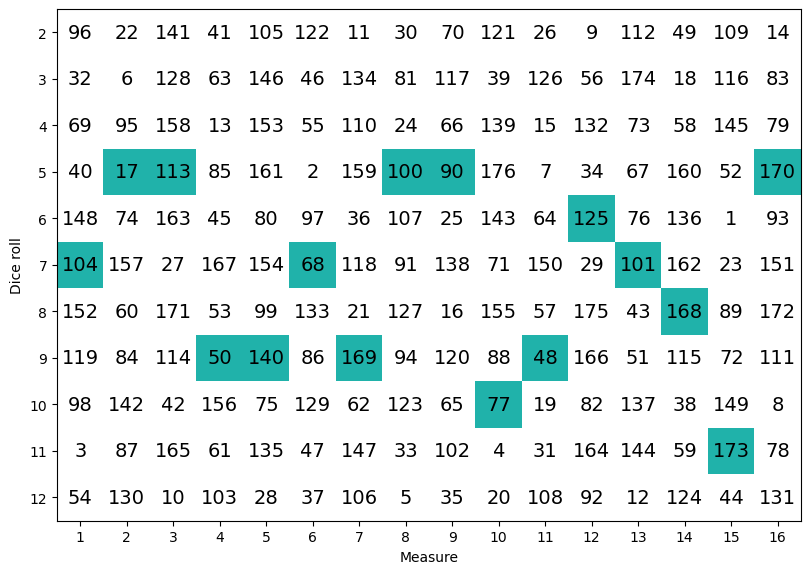

In [5]:
plot_number_table(number_table, dice_rolls)

## Music fragments

In [6]:
midi_file = mido.MidiFile('musikalisches_wuerfelspiel.mid')

In [7]:
def get_fragment(midi_file, time_start, time_end):
    proc_time = 0.0
    
    for msg in midi_file:
        if not isinstance(msg, mido.MetaMessage) and msg.type != 'control_change':
            proc_time += msg.time
            if proc_time >= time_start and proc_time <= time_end:
                yield msg                

In [8]:
def get_control_change_messages(midi_file):
    for msg in midi_file:
        if not isinstance(msg, mido.MetaMessage) and msg.type == 'control_change':
            yield msg

In [9]:
def get_measure_index(number_table, number):
    eighth_column = number_table[:, 7]  # 7 represents the 8th column
    count = np.sum(eighth_column < number)
    return number + count

In [10]:
def get_dice_roll_fragments(midi_file, number_table, dice_rolls):
    measure_duration = sum([msg.time for msg in midi_file if not isinstance(msg, mido.MetaMessage)]) / (number_table.shape[0] * (number_table.shape[1]+1))
    measures = number_table[dice_rolls - 2, np.arange(16)]

    yield from get_control_change_messages(midi_file)
    
    for i in range(2): # repeat measures 1 to 8
        for j in range(0, 8):
            index = get_measure_index(number_table, measures[j]) + (i if j == 7 else 0)
            yield from get_fragment(midi_file, measure_duration * (index-1), measure_duration * index)
    for j in range(8, 16):
        index = get_measure_index(number_table, measures[j])
        yield from get_fragment(midi_file, measure_duration * (index-1), measure_duration * index)

In [11]:
def play_dice_roll_fragments(midi_file, number_table, dice_rolls):
    # generate all MIDI messages in advance
    messages = list(get_dice_roll_fragments(midi_file, number_table, dice_rolls))
    
    start_time = time.time()
    input_time = 0.0

    for msg in messages:
        input_time += msg.time
    
        playback_time = time.time() - start_time
        duration_to_next_event = input_time - playback_time
    
        if duration_to_next_event > 0.0:
            time.sleep(duration_to_next_event)
    
        yield msg

## Building a GUI

In [12]:
output_dropdown = widgets.Dropdown(
    options=np.unique(mido.get_output_names()),
    description='MIDI output:',
    disabled=False,
)

randomize_button = widgets.Button(icon='dice', description='Throw dice')
play_button = widgets.Button(icon='play', description='Play')

output = widgets.Output()

hbox = widgets.HBox([randomize_button, play_button])
vbox = widgets.VBox([output_dropdown, hbox, output])

In [13]:
def randomize_button_clicked(b=None):
    global dice_rolls
    dice_rolls = np.sum(np.random.randint(1, 7, size=(2, 16)), axis=0)
    with output:
        output.clear_output(wait=True)
        plot_number_table(number_table, dice_rolls)

randomize_button.on_click(randomize_button_clicked)

In [14]:
def play_button_clicked(b):    
    midi_output = mido.open_output(output_dropdown.value)
    
    for msg in play_dice_roll_fragments(midi_file, number_table, dice_rolls):
        midi_output.send(msg)
    
play_button.on_click(play_button_clicked)

In [15]:
randomize_button_clicked()

display(vbox)